In [1]:
import networkx as nx
import warnings
import datetime
import seaborn as sn
sn.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from ast import literal_eval
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
passengers = pd.read_csv("Results/passengers.csv")
passengers = passengers[['route', 'origin', 'destination', 'transfers', 'transferstations']]
passengers['route'] = passengers['route'].apply(lambda x: literal_eval(x))

In [3]:
# singletrip = passengers[passengers['transfers'] == 0]

# ordest = []

# for index, row in singletrip.iterrows():
#     ordest.append((row['route'][0], row['route'][-1]))

In [4]:
transfertrips = passengers[passengers['transfers'] > 0]
transfertrips['transferstations'] = transfertrips['transferstations'].apply(lambda x: literal_eval(x))
split_lists = []

for index, row in transfertrips.iterrows():
    route = row['route']
    indexes = []
    
    for transfer in row['transferstations']:
        split = route.index((transfer)) + 1
        indexes.append(split)

    start = 0
    
    for index in indexes:
        split_lists.append(route[start:index])
        start = index - 1
    split_lists.append(route[start:])

In [6]:
ordest = []
for i in range(len(split_lists)):
    ordest.append((split_lists[i][0], split_lists[i][-1]))

In [7]:
herbest = pd.read_csv('../../Data/20190403/Datalab_Rit_Herkomst_Bestemming_Uur_20190403.csv', sep=';')

In [8]:
# List of all stations in the sub-network
stations = ['Amsteldijk','Amstelstation','Amstelveenseweg','Beethovenstraat','Bullewijk','Burg.de Vlugtlaan', 
    'Centraal Station','Cornelis Troostplein','Dam','De Boelelaan/VU','De Pijp','Europaplein',
    'Gaasperplas','Gein','Gerrit v.d. Veenstraat','Heemstedestraat','Henk Sneevlietweg','IJsbaanpad', 
    'Isolatorweg','Jan v.Galenstraat','Keizersgracht','Koningsplein','Kraaienneststation','Leidseplein',
    'Maasstraat','Marie Heinekenplein','Minervaplein','Muntplein','Museumplein','Nieuwezijds Kolk',
    'Nieuwmarkt','Noord','Noorderpark','Olympiaplein','Olympiaweg','Olympisch stadion','Overamstel', 
    'Postjesweg','Prinsengracht','Reigersbos','Rijksmuseum','Roelof Hartplein','Rokin','Scheldestraat',
    'Spaklerweg','Spui','Station Bijlmer ArenA','Station Diemen-Zuid','Station Duivendrecht', 'Stadionweg'
    'Station Ganzenhoef','Station Holendrecht','Station Lelylaan','Station RAI','Station Sloterdijk', 
    'Strandvliet','Van Baerlestraat','Van der Madeweg','Venserpolder','Verrijn Stuartweg','Victorieplein', 
    'Vijzelgracht','VU medisch centrum','Waalstraat','Waterlooplein','Weesperplein','Wibautstraat','Station Zuid']

In [9]:
herbest['Datum'] = herbest['Datum'].apply(lambda x: datetime.datetime.strptime(x[:-3], '%m/%d/%Y %H:%M:%S'))
herbest['Weekdag'] = herbest['Datum'].apply(lambda x: x.isoweekday())

In [10]:
herbest = herbest[herbest['Datum'] >= datetime.datetime(2018, 8, 1)]

In [11]:
herbest = herbest[(herbest['VertrekHalteNaam'].isin(stations)) & (herbest['Weekdag'] == 1)]
herbest = herbest[(herbest['AankomstHalteNaam'].isin(stations))]

In [12]:
herbest = herbest[herbest['UurgroepOmschrijving (van vertrek)'] == '06:00 - 06:59']
herbest.head()

,Datum,UurgroepOmschrijving (van vertrek),VertrekHalteCode,VertrekHalteNaam,VertrekLat,VertrekLon,AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalRitten,Weekdag
4625282,2018-08-06 12:00:00,06:00 - 06:59,02221,Jan v.Galenstraat,4.858423,52.375326,02361,Station Sloterdijk,4.839319,52.388335,14,1
4625339,2018-08-06 12:00:00,06:00 - 06:59,05011,Centraal Station,4.899218,52.378108,05065,Dam,4.890794,52.373678,28,1
4625343,2018-08-06 12:00:00,06:00 - 06:59,05011,Centraal Station,4.899218,52.378108,06072,Prinsengracht,4.884284,52.364959,18,1
4625344,2018-08-06 12:00:00,06:00 - 06:59,05011,Centraal Station,4.899218,52.378108,06076,Koningsplein,4.888579,52.366892,15,1
4625345,2018-08-06 12:00:00,06:00 - 06:59,05011,Centraal Station,4.899218,52.378108,06089,Leidseplein,4.880855,52.363093,32,1


In [13]:
stopdict = {'ITW': 1, 'GN': 1, 'RAI': 1, 'VSW': 1, 'ND': 1, 'RKN': 1, 
            'WPP': 1, 'RGB': 1, 'HVW': 1, 'OAS': 1, 'CLL': 1, 'PJW': 1, 
            'BLW': 1, 'WBS': 1, 'HLD': 1, 'MDW': 1, 'SVT': 1, 'DMZ': 1, 
            'BMR': 1, 'EPP': 1, 'WTC': 1, 'DPP': 1, 'JLS': 1, 'DVD': 1, 
            'GZH': 1, 'NDP': 1, 'NMT': 1, 'VLN': 1, 'ASA': 1, 'KEN': 1, 
            'VPD': 1, 'SLW': 1, 'WLP': 1, 'HDS': 1, 'GPP': 1, 'VZG': 1, 
            'CS': 1, 'VU': 1, 'ASW': 1, 'STD': 1, '08070': 1, '09122': 1, 
            '09121': 1, '07094': 1, '07091': 1, '08071': 1, '09013': 1, 
            '07004': 1, '08076': 1, '08078': 1, '07307': 1, '07308': 1, 
            '07120': 2, '07108': 2, '09083': 2, '09082': 2, '07202': 2, 
            '07121': 2, '09078': 2, '09079': 2, '07084': 2, '07083': 2, 
            '07207': 2, '07205': 2, '07017': 2, '07303': 2, '07350': 2, 
            '09074': 2, '09075': 2, '07098': 2, '07097': 2, '07493': 2, 
            '07490': 2, '09119': 2, '09120': 2, '05036': 3, '05035': 3, 
            '06072': 3, '06071': 3, '06075': 3, '06076': 3, '06073': 3, 
            '06074': 3, '07015': 3, '09049': 3, '09051': 3, '05062': 3, 
            '05061': 3, '07006': 3, '07007': 3, '07322': 3, '07321': 3, 
            '07323': 3, '07324': 3, '06067': 3, '05063': 3, '05032': 3, 
            '05031': 3, '07016': 0.6666666666666666, '09114': 0.6666666666666666, 
            '09111': 0.6666666666666666, '09139': 4, '09140': 4, '05022': 4, 
            '05011': 5, '06089': 5, '05065': 5, '05070': 5, '05069': 5}

In [14]:
herbest = herbest[herbest['VertrekHalteCode'].isin(stopdict.keys())]
herbest = herbest[herbest['AankomstHalteCode'].isin(stopdict.keys())]
herbest = herbest[herbest['AankomstHalteNaam'] != herbest['VertrekHalteNaam']]

In [15]:
herbest['AantalLijnenVertrek'] = herbest['VertrekHalteCode'].map(stopdict)
herbest['AantalLijnenAankomst'] = herbest['AankomstHalteCode'].map(stopdict)
herbest['AantalLijnen'] = np.where(herbest.AantalLijnenVertrek > herbest.AantalLijnenAankomst, 
         herbest.AantalLijnenAankomst, herbest.AantalLijnenVertrek)

In [16]:
herbest['AantalRittenNorm'] = herbest['AantalRitten']/herbest['AantalLijnen']

In [17]:
herbest

,Datum,UurgroepOmschrijving (van vertrek),VertrekHalteCode,VertrekHalteNaam,VertrekLat,VertrekLon,AankomstHalteCode,AankomstHalteNaam,AankomstLat,AankomstLon,AantalRitten,Weekdag,AantalLijnenVertrek,AantalLijnenAankomst,AantalLijnen,AantalRittenNorm
4625339,2018-08-06 12:00:00,06:00 - 06:59,05011,Centraal Station,4.899218,52.378108,05065,Dam,4.890794,52.373678,28,1,5.0,5.0,5.0,5.600000
4625343,2018-08-06 12:00:00,06:00 - 06:59,05011,Centraal Station,4.899218,52.378108,06072,Prinsengracht,4.884284,52.364959,18,1,5.0,3.0,3.0,6.000000
4625344,2018-08-06 12:00:00,06:00 - 06:59,05011,Centraal Station,4.899218,52.378108,06076,Koningsplein,4.888579,52.366892,15,1,5.0,3.0,3.0,5.000000
4625345,2018-08-06 12:00:00,06:00 - 06:59,05011,Centraal Station,4.899218,52.378108,06089,Leidseplein,4.880855,52.363093,32,1,5.0,5.0,5.0,6.400000
4625346,2018-08-06 12:00:00,06:00 - 06:59,05011,Centraal Station,4.899218,52.378108,07321,Van Baerlestraat,4.878958,52.358277,13,1,5.0,3.0,3.0,4.333333
4625347,2018-08-06 12:00:00,06:00 - 06:59,05011,Centraal Station,4.899218,52.378108,07323,Rijksmuseum,4.883550,52.359770,10,1,5.0,3.0,3.0,3.333333
4625349,2018-08-06 12:00:00,06:00 - 06:59,05022,Centraal Station,4.901043,52.377720,05031,Dam,4.893484,52.373411,21,1,4.0,3.0,3.0,7.000000
4625350,2018-08-06 12:00:00,06:00 - 06:59,05022,Centraal Station,4.901043,52.377720,05035,Rokin,4.892104,52.369396,15,1,4.0,3.0,3.0,5.000000
4625385,2018-08-06 12:00:00,06:00 - 06:59,06067,Leidseplein,4.883014,52.364316,05011,Centraal Station,4.899218,52.378108,21,1,3.0,5.0,3.0,7.000000
4625394,2018-08-06 12:00:00,06:00 - 06:59,07493,Amstelveenseweg,4.857250,52.338345,07303,VU medisch centrum,4.860971,52.335153,15,1,2.0,2.0,2.0,7.500000


In [18]:
simulationdict = dict(Counter(ordest))

In [19]:
datadict = {}
for index, row in herbest.iterrows():
    datadict[(row['VertrekHalteNaam'], row['AankomstHalteNaam'])] = row['AantalRittenNorm']

In [20]:
simulation = pd.DataFrame.from_dict(simulationdict, orient='index')
simulation = simulation.reset_index()

In [21]:
data = pd.DataFrame.from_dict(datadict, orient='index')
data = data.reset_index()
# data.columns = [['Stations', 'DataTrips']]

In [22]:
combined = pd.merge(simulation, data, on=['index'])

In [23]:
combined.columns = [['stations', 'simulation', 'data']]

In [24]:
combined = combined.fillna(value=0)

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
mean_absolute_error(combined['data'], combined['simulation'])

24.130059523809525

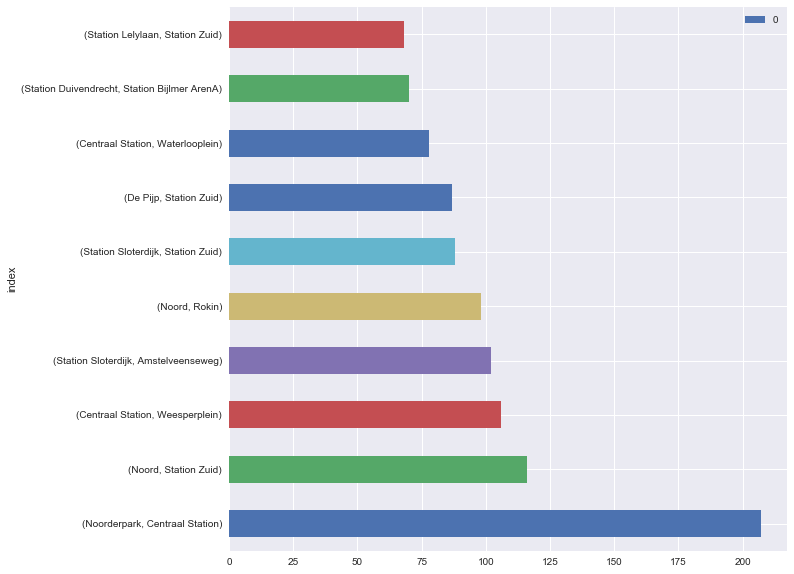

In [26]:
dataplot = (data.sort_values(by = 0, ascending = False)).head(10)
dataplot.plot(kind = 'barh', x = 'index', y = 0, figsize = [10,10])

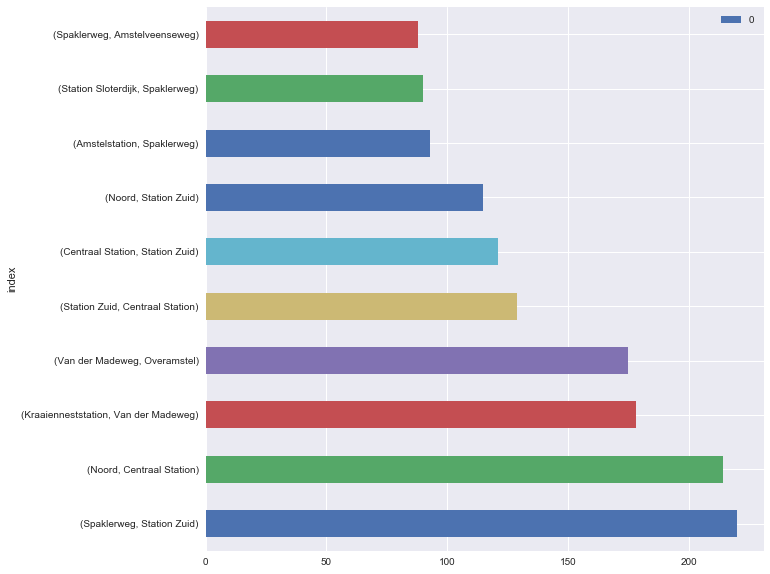

In [27]:
simulationplot = (simulation.sort_values(by = 0, ascending = False)).head(10)
simulationplot.plot(kind = 'barh', x = 'index', y = 0, figsize = [10,10])

In [42]:
combined['difference'] = combined['simulation'] - combined['data']

In [43]:
combined

,stations,simulation,data,difference
0,"(Postjesweg, Station Zuid)",19,21.000000,NaN
1,"(Station Zuid, Centraal Station)",129,31.000000,NaN
2,"(Station Duivendrecht, Spaklerweg)",58,16.000000,NaN
3,"(Spaklerweg, Station Zuid)",220,12.000000,NaN
4,"(Vijzelgracht, Station Zuid)",16,56.000000,NaN
5,"(Station Zuid, Henk Sneevlietweg)",40,31.000000,NaN
6,"(Noorderpark, Station Zuid)",32,47.000000,NaN
7,"(Amstelstation, Spaklerweg)",93,13.000000,NaN
8,"(Noord, Station Zuid)",115,116.000000,NaN
9,"(Centraal Station, Station Zuid)",121,49.000000,NaN
